In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

GRID_LENGTH = 4
GRID_WIDTH = 12
ACTION_NUM = 4
GAMMA = 1 # discounting rate
ACTIONS = [(-1,0), (1,0), (0,-1), (0,1)] # up, down, left and right
START = (GRID_LENGTH-1, 0)
GOAL = (GRID_LENGTH-1, GRID_WIDTH-1)

In [2]:
# @return: reward and new_state
def choose_action(state, q_value, epsilon):
    i, j = state
    assert 0 <= i < GRID_LENGTH
    assert 0 <= j < GRID_WIDTH
    if np.random.random() < epsilon:
        action = np.random.randint(ACTION_NUM)
    else:
        maxidx = [idx for idx in range(ACTION_NUM) if q_value[i,j,idx]==max(q_value[i,j,:])]
        action = np.random.choice(maxidx)          # broken arbitrarily with ties

    #### rebound when hitting the boundary #######
    #### action: 0-up, 1-down, 2-left, 3-right ####
#     if i == 0 and action == 0:
#         action = 1
#     elif i == GRID_LENGTH - 1 and action == 1:
#         action = 0
#     if j == 0 and action == 2:
#         action = 3
#     elif j == GRID_WIDTH - 1 and action == 3:
#         action = 2

    return action


# @return: reward and the new state
def walk(state, action):
    assert 0 <= action < ACTION_NUM
    i, j = state
    di, dj = ACTIONS[action]
    i, j = min(max(0, di+i), GRID_LENGTH-1), min(max(0, dj+j), GRID_WIDTH-1)    # stand still when hitting the boundary
    if i == GRID_LENGTH - 1 and 1 <= j < GRID_WIDTH - 1: # i=3 and 1<=j<=10
        reward = -100
        new_state = START
    else:
        reward = -1
        new_state = (i, j)
    return reward, new_state

# @alpha: step size for undating# @return: sum of rewards within an episode
def sarsa(q_value, alpha, expected=False, epsilon=0.1, gamma=GAMMA):
    state = START
    rewards = 0
    action = choose_action(state, q_value, epsilon)
    while state != GOAL:
        reward, new_state = walk(state, action)
        rewards += reward
        new_action = choose_action(new_state, q_value, epsilon)
        if expected:
            i, j = new_state[0], new_state[1]
            maxidx = [idx for idx in range(ACTION_NUM) if q_value[i,j,idx]==max(q_value[i,j,:])]
            expectation = 0
            for idx in range(ACTION_NUM):
                if idx in maxidx:
                    expectation += ((1 - epsilon)/len(maxidx) + epsilon/ACTION_NUM)*q_value[i, j, idx]
                else:
                    expectation += epsilon/ACTION_NUM*q_value[i, j, idx]
            q_value[state[0],state[1],action] += alpha*(reward + gamma*expectation - q_value[state[0], state[1], action])
        else:
            q_value[state[0],state[1],action] += alpha*(reward + \
                gamma*q_value[new_state[0], new_state[1], new_action] - q_value[state[0], state[1], action])       
        state = new_state
        action = new_action
    return rewards

def q_learning(q_value, alpha, epsilon=0.1, gamma=GAMMA):
    state = START
    rewards = 0
    while state != GOAL:
        action = choose_action(state, q_value, epsilon)
        reward, new_state = walk(state, action)
        rewards += reward
        q_value[state[0], state[1], action] += alpha*(reward + \
        gamma*max(q_value[new_state[0], new_state[1], :]) - q_value[state[0], state[1], action])
        state = new_state
    return rewards

100%|████████████████████████████████████████| 500/500 [06:31<00:00,  1.33it/s]


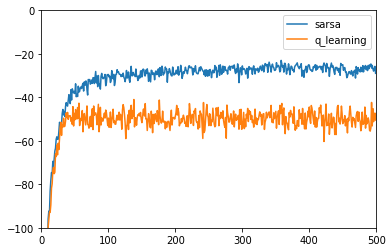

In [12]:
runs = 500
episodes = 500
epsilon = 0.1                            # TODO: how about descending over time?
alpha = 0.5                              # step size
rewards_sarsa = np.zeros(episodes)
rewards_q_learning = np.zeros(episodes)

for i in tqdm(range(runs)):
    q_sarsa = np.zeros((GRID_LENGTH, GRID_WIDTH, ACTION_NUM))
    q_q_learning = q_sarsa.copy()

    for episode in range(episodes):
        rewards_sarsa[episode] += sarsa(q_sarsa, alpha, epsilon=0.1, gamma=GAMMA)
        rewards_q_learning[episode] += q_learning(q_q_learning, alpha, epsilon=0.1, gamma=GAMMA)

rewards_sarsa /= runs
rewards_q_learning /= runs

plt.plot(range(episodes), rewards_sarsa, label='sarsa')
plt.plot(range(episodes), rewards_q_learning, label='q_learning')
plt.legend()
plt.axis([0,episodes,-100,0])
plt.show()

## Expected Sarsa: figure 6.3

100%|██████████████████████████████████████████| 50/50 [10:07<00:00,  6.95s/it]


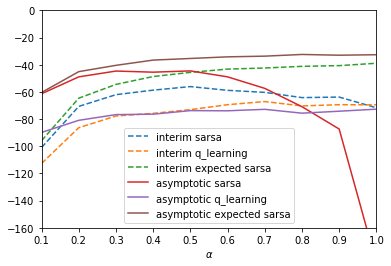

In [5]:
runs = 50 # for interim cases
run_asymptotic = 10
episodes = 1000 # for asymptotic performance
episode_interim = 100
alpha_num = 10
rewards_sarsa = np.zeros((alpha_num, 2)) 
rewards_q_learning = np.zeros((alpha_num, 2))
rewards_expected_sarsa = np.zeros((alpha_num, 2))

for run in tqdm(range(runs)):
    for alpha in np.arange(0.1, 1.1, 0.1):
        q_sarsa = np.zeros((GRID_LENGTH, GRID_WIDTH, ACTION_NUM))
        q_expected_sarsa = q_sarsa.copy()
        q_q_learning = q_sarsa.copy()

        for episode in range(episodes):
            if episode >= episode_interim and run >= run_asymptotic:
                break
            if episode <= episode_interim - 1:
                rewards_sarsa[int(alpha*10-1), 0] += sarsa(q_sarsa, alpha)
                rewards_q_learning[int(alpha*10-1), 0] += q_learning(q_q_learning, alpha)
                rewards_expected_sarsa[int(alpha*10-1), 0] += sarsa(q_expected_sarsa, alpha, expected=True)
            rewards_sarsa[int(alpha*10-1), 1] += sarsa(q_sarsa, alpha)
            rewards_q_learning[int(alpha*10-1), 1] += q_learning(q_q_learning, alpha)
            rewards_expected_sarsa[int(alpha*10-1), 1] += sarsa(q_expected_sarsa, alpha, expected=True)

rewards_sarsa[:, 0] /= runs*episode_interim
rewards_q_learning[:, 0] /= runs*episode_interim
rewards_expected_sarsa[:, 0] /= runs*episode_interim
rewards_sarsa[:, 1] /= run_asymptotic*episodes
rewards_q_learning[:, 1] /= run_asymptotic*episodes
rewards_expected_sarsa[:, 1] /= run_asymptotic*episodes

plt.plot(range(alpha_num), rewards_sarsa[:,0], label='interim sarsa', linestyle='dashed')
plt.plot(range(alpha_num), rewards_q_learning[:,0], label='interim q_learning', linestyle='dashed')
plt.plot(range(alpha_num), rewards_expected_sarsa[:,0], label='interim expected sarsa', linestyle='dashed')
plt.plot(range(alpha_num), rewards_sarsa[:,1], label='asymptotic sarsa')
plt.plot(range(alpha_num), rewards_q_learning[:,1], label='asymptotic q_learning')
plt.plot(range(alpha_num), rewards_expected_sarsa[:,1], label='asymptotic expected sarsa')
plt.legend()
plt.axis([0, 9, -160,0])
plt.xticks(range(0,10), np.round((np.arange(0.1,1.1,0.1)),1))
plt.xlabel(r'$\alpha$')
plt.show()